In [111]:
# playground for GNN data processing

import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch as th


import os

In [112]:
# extract filenames from npy_GNN folder

def get_filenames(directory):
    filenames = []
    for file in os.listdir(f"../npy_GNN/{directory}"):
        if file[-4:] == ".npy":
            filenames.append(file)
    filenames.sort()
    return filenames

names = get_filenames("2024-05-15_11:57:51_dynamic")
print(names)

# create a second list with the same filenames but without everything after the first underscore

def get_filenames_no_time(directory):
    filenames = []
    for file in os.listdir(f"../npy_GNN/{directory}"):
        if file[-4:] == ".npy":
            filenames.append(file)
    filenames.sort()
    for i in range(len(filenames)):
        filenames[i] = filenames[i].split("_")[0] + ".npy"
    return filenames

names_no_time = get_filenames_no_time("2024-05-15_11:57:51_dynamic")
types = len(set(names_no_time))

samples = len(names) // types
print(types, samples)

['CoarseResPoints_10.789_x_-0.283_y_0.959.npy', 'CoarseResPoints_11.324_x_-0.578_y_0.816.npy', 'CoarseResPoints_11.577_x_-0.049_y_0.999.npy', 'CoarseResPoints_12.313_x_0.79_y_-0.614.npy', 'CoarseResPoints_13.037_x_0.269_y_0.963.npy', 'CoarseResPoints_13.537_x_0.798_y_0.603.npy', 'CoarseResPoints_13.746_x_-0.944_y_0.33.npy', 'CoarseResPoints_14.492_x_1.0_y_0.026.npy', 'CoarseResPoints_15.447_x_-0.979_y_0.202.npy', 'CoarseResPoints_15.796_x_0.671_y_-0.741.npy', 'CoarseResPoints_15.811_x_0.434_y_0.901.npy', 'CoarseResPoints_16.065_x_-0.327_y_-0.945.npy', 'CoarseResPoints_16.365_x_-0.777_y_0.629.npy', 'CoarseResPoints_16.95_x_-0.085_y_-0.996.npy', 'CoarseResPoints_17.222_x_-0.673_y_0.74.npy', 'CoarseResPoints_17.284_x_-0.365_y_-0.931.npy', 'CoarseResPoints_17.359_x_-0.877_y_0.48.npy', 'CoarseResPoints_17.643_x_1.0_y_0.005.npy', 'CoarseResPoints_19.718_x_0.161_y_0.987.npy', 'CoarseResPoints_20.173_x_-0.817_y_0.577.npy', 'CoarseResPoints_21.045_x_0.53_y_-0.848.npy', 'CoarseResPoints_22.494_x

In [113]:

# create a function to transform the data into a list of Data objects

from torch import le


def extract_identifier(filename):
    # extract the identifier from the filename
    return int(filename.split('_')[-1].replace('.npy', ''))

def create_data_list(directory):
    names_unsorted = get_filenames(directory)
    
    names = sorted(names_unsorted, key=lambda x: (extract_identifier(x), x))
    print(len(names))
    samples = len(names) // 6
    data_list = []
    for i in range(samples - 1):
        low_res_displacement = np.load(f"../npy_GNN/{directory}/{names[i*6]}")
        high_res_displacement = np.load(f"../npy_GNN/{directory}/{names[i*6+3]}")
        high_res_velocity = np.load(f"../npy_GNN/{directory}/{names[i*6+4]}")
        low_res_velocity = np.load(f"../npy_GNN/{directory}/{names[i*6+5]}")
        node_features = np.hstack((low_res_displacement, high_res_displacement, low_res_velocity, high_res_velocity))
        edge_index = np.load(f"../npy_GNN/{directory}/{names[i*6+2]}")[:, :2].T
        edge_attr = np.load(f"../npy_GNN/{directory}/{names[i*6+2]}")[:, 2]
        y = high_res_displacement - low_res_displacement
        data = Data(x=th.tensor(node_features, dtype=th.float32), edge_index=th.tensor(edge_index, dtype=th.long), edge_attr=th.tensor(edge_attr, dtype=th.float32), y=th.tensor(y, dtype=th.float32))
        data_list.append(node_features)
    return data_list

data_list = create_data_list("2024-08-07_17:40:37_dynamic")

print(len(data_list))



340800
56799


In [114]:
for i in range(10):
    print(data_list[i][44,4]) 

0.004235689114447345
0.11679988752536584
0.29891532075846977
0.4057188696335759
0.3610497242722771
0.21075599731949884
0.08034906959848445
0.07073910105939245
0.1803518049448708
0.3144532239476579


In [115]:
print(data_list[0].shape)
val_data_list = create_data_list("2024-08-08_14:35:35_dynamic")

(75, 12)
24000


In [116]:
data = np.empty((len(data_list), 4, 100))
val_data = np.empty((len(val_data_list), 4, 100))


for i in range(len(data_list)-100):
    for time in range(100):
        data[i, 0, time] = data_list[i+time][44, 1] #low_res_displacement
        data[i, 1, time] = data_list[i+time][44, 4] #high_res_displacement 
        data[i, 2, time] = data_list[i+time][44, 7] #low_res_velocity
        data[i, 3, time] = data_list[i+time][44, 10] #high_res_velocity

for i in range(len(val_data_list)-100):
    for time in range(100):
        val_data[i, 0, time] = val_data_list[i+time][44, 1]
        val_data[i, 1, time] = val_data_list[i+time][44, 4]
        val_data[i, 2, time] = val_data_list[i+time][44, 7]
        val_data[i, 3, time] = val_data_list[i+time][44, 10]




In [117]:
print(data[0, 0, :])


[0.00422231 0.11505959 0.28652595 0.36763499 0.29756842 0.14936908
 0.05758511 0.09668642 0.22189471 0.31775349 0.30398598 0.20175637
 0.10678435 0.10056643 0.18089241 0.27115314 0.29242861 0.23230025
 0.14944564 0.11746547 0.15961695 0.23331894 0.27213067 0.24559053
 0.18204679 0.13960313 0.15303543 0.20606562 0.24954867 0.24673592
 0.20398902 0.16148284 0.15604907 0.18917282 0.22913411 0.24067452
 0.21634971 0.1801134  0.16437007 0.18086031 0.21268396 0.23097674
 0.22120252 0.19409691 0.17457757 0.17880514 0.2011548  0.22082577
 0.2210184  0.20325763 0.18430664 0.18071125 0.19420371 0.21182849
 0.21793697 0.20826611 0.19241246 0.18460592 0.19089418 0.20469226
 0.2135024  0.21009676 0.1984591  0.18919519 0.1902066  0.19972752
 0.20904267 0.21001517 0.20246045 0.19328964 0.19056068 0.19637839
 0.20522373 0.20962206 0.2055389  0.19725452 0.19215554 0.19441111
 0.20140389 0.20736486 0.20675038 0.20061725 0.19365817 0.18671625
 0.1798075  0.17294571 0.16721112 0.18276493 0.21210177 0.2286

In [118]:
# val_data_list = create_data_list("2024-08-09_16:45:10_dynamic")
# val_data = np.empty((len(val_data_list), 4, 100))
# for i in range(len(val_data_list)):
#     for time in range(100):
#         val_data[i, 0, time] = val_data_list[time][44, 1]
#         val_data[i, 1, time] = val_data_list[time][44, 4]
#         val_data[i, 2, time] = val_data_list[time][44, 7]
#         val_data[i, 3, time] = val_data_list[time][44, 10]


In [119]:
#statistics
print(data.shape)
print(val_data.shape)

print(f"Max displacement: {np.max(data[:, 1, :])}")
print(f"Min displacement: {np.min(data[:, 1, :])}")
print(f"Max velocity: {np.max(data[:, 3, :])}")
print(f"Min velocity: {np.min(data[:, 3, :])}")
print("Negative values:")
print(f"Displacement: {np.sum(data[:, 1, :] < 0)}")
print("validation")
print(f"Max displacement: {np.max(val_data[:, 1, :])}")
print(f"Min displacement: {np.min(val_data[:, 1, :])}")
print(f"Max velocity: {np.max(val_data[:, 3, :])}")
print(f"Min velocity: {np.min(val_data[:, 3, :])}")



(56799, 4, 100)
(3999, 4, 100)
Max displacement: 6.32422858367161
Min displacement: -6.340821435427643
Max velocity: 26.287382124639333
Min velocity: -26.176387434769435
Negative values:
Displacement: 2838450
validation
Max displacement: 5.021181021858023
Min displacement: -5.648614641159301
Max velocity: 20.85670504115791
Min velocity: -23.05519926876246


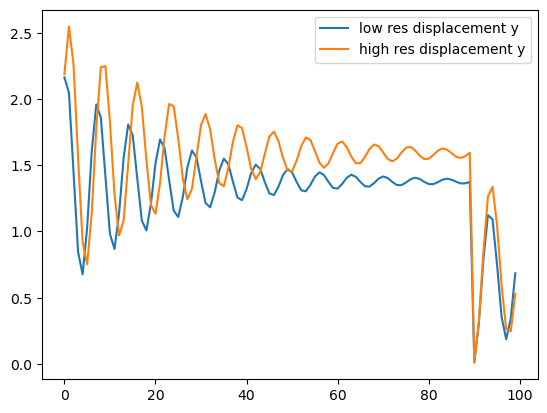

In [123]:

import matplotlib.pyplot as plt

plt.plot(val_data[10, 0, :], label="low res displacement y")
plt.plot(val_data[10, 1, :], label="high res displacement y")
plt.legend()
plt.show()
# plt.plot(data[0, 2, :], label="low res velocity y")
# plt.plot(data[0, 3, :], label="high res velocity y")

epoch: 0, loss: 0.30012275258431564
validation loss: 0.2646158860316352
epoch: 1, loss: 0.2731443761369666
Counter: 1
Diff: 2.4658110406694522e-05
validation loss: 0.2646405441420419
epoch: 2, loss: 0.27299969692018117
validation loss: 0.2617328062890068
epoch: 3, loss: 0.27226649152601623
Counter: 1
Diff: 0.0017062785133482583
validation loss: 0.26343908480235506
epoch: 4, loss: 0.2712427907631741
validation loss: 0.2607320066955354
epoch: 5, loss: 0.2689477555151727
validation loss: 0.25434384767025237
epoch: 6, loss: 0.26054271770355936
validation loss: 0.2516347039786596
epoch: 7, loss: 0.25864451457452664
validation loss: 0.24848648787490904
epoch: 8, loss: 0.25217247769437934
validation loss: 0.24358851450776298
epoch: 9, loss: 0.24948182678571693
validation loss: 0.24073386192321777
epoch: 10, loss: 0.24913388997450606
validation loss: 0.23868812975429354
epoch: 11, loss: 0.2486506081983313
Counter: 1
Diff: 0.0014551525551175226
validation loss: 0.24014328230941107
epoch: 12, lo

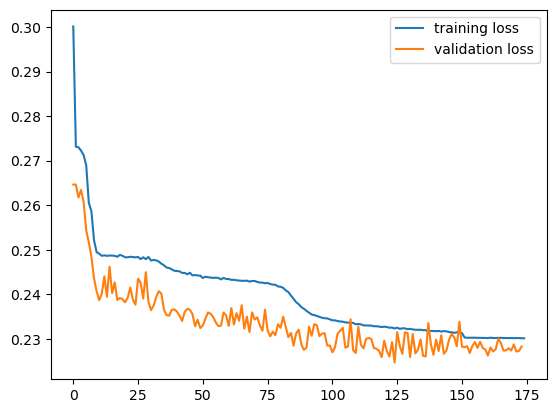

In [121]:

from logging import logProcesses
import torch.nn.functional as F
import tqdm

class Net(th.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = th.nn.Linear(3, 64)
        self.linear2 = th.nn.Linear(64, 32)
        self.linear3 = th.nn.Linear(32, 16)
        self.linear4 = th.nn.Linear(16, 1)

    def forward(self, x):
        x = th.sin(self.linear1(x))
        x = th.sin(self.linear2(x))
        x = th.sin(self.linear3(x))
        x = self.linear4(x)
        return x
    
class RMSELoss(th.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = th.nn.MSELoss()
    
    def forward(self, yhat, y):
        return th.sqrt(self.mse(yhat, y))
    
class MixedLoss(th.nn.Module):
    # Custom loss function that computes the weighted sum between the root mean squared error and the maximum absolute error
    def __init__(self):
        super(MixedLoss, self).__init__()

    def forward(self, pred, true):
        # select the indices where the absolute value is greater than 1
        mask = th.abs(true) > 0.5
        if th.sum(mask) > 20:
            loss1 = th.sqrt(th.mean(th.square(pred[mask] - true[mask])))
            loss2 = th.sqrt(th.mean(th.square(pred[~mask] - true[~mask])))
            return 0.7*loss1 + 0.3*loss2
        else:
            loss1 = th.sqrt(th.mean(th.square(pred - true)))
            loss2 = th.max(th.abs(pred - true))
            return 0.7*loss1 + 0.3*loss2
    
class Dataset(th.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)
        self.y_displacement = self.data[:, 0, :]
        self.y_displacement = (self.y_displacement - np.min(self.y_displacement)) / (np.max(self.y_displacement) - np.min(self.y_displacement))
        self.y_velocity = self.data[:, 2, :]
        self.y_velocity = (self.y_velocity - np.min(self.y_velocity)) / (np.max(self.y_velocity) - np.min(self.y_velocity))
        self.timestep = np.arange(100)
        #create a list of tuples with the y displacement and the timestep
        self.inputs = np.empty((self.length, 100, 3))
        for i in range(self.length):
            self.inputs[i, :, 0] = self.y_displacement[i]
            self.inputs[i, :, 1] = self.timestep
            self.inputs[i, :, 2] = self.y_velocity[i]
        self.inputs = th.tensor(self.inputs, dtype=th.float32)
        self.outputs = th.tensor(self.data[:, 1, :] - self.data[:, 0, :], dtype=th.float32)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, lr = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.lr = lr

    def early_stop(self, validation_loss, learning_rate):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif learning_rate != self.lr:
            self.lr = learning_rate
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"Counter: {self.counter}")
            print(f"Diff: {validation_loss - self.min_validation_loss}")
            if self.counter >= self.patience:
                return True
        return False
    
dataset = Dataset(data)
dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
val_dataset = Dataset(val_data)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = th.optim.Adam(model.parameters(), lr=0.001)
criterion = RMSELoss()
model.train()
losses = []
val_losses = []
early_stopper = EarlyStopper(patience=50, min_delta=1e-7, lr=0.001)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, min_lr=1e-8)
for epoch in range(1000):
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"epoch: {epoch}, loss: {running_loss / len(dataloader)}")
    losses.append(running_loss / len(dataloader))
    val_loss = 0.0
    for i, batch in enumerate(val_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    if early_stopper.early_stop(val_loss / len(val_dataloader), 0.001):
        print("Early stopping")
        break
    scheduler.step(val_loss / len(val_dataloader))
    

    print(f"validation loss: {val_loss / len(val_dataloader)}")
    val_losses.append(val_loss / len(val_dataloader))





#plot the losses
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()




(56799, 100, 1)
(56799, 100, 1)
(56799, 4, 100)


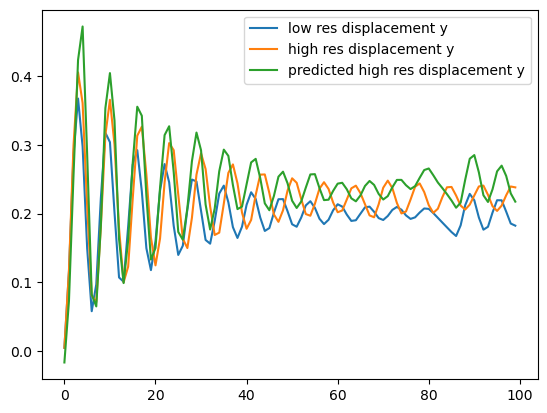

In [125]:
model.eval()
with th.no_grad():
    predictions = model(dataset.inputs.to(device)).cpu().numpy()
    print(predictions.shape)

print(predictions.shape)
print(data.shape)
plt.figure()
plt.plot(data[0, 0, :], label="low res displacement y")
plt.plot(data[0, 1, :], label="high res displacement y")
plt.plot(data[0, 0, :] + predictions[0, :, 0], label="predicted high res displacement y")
plt.legend()
plt.show()

(3999, 100, 1)
(3999, 100, 1)
(3999, 4, 100)


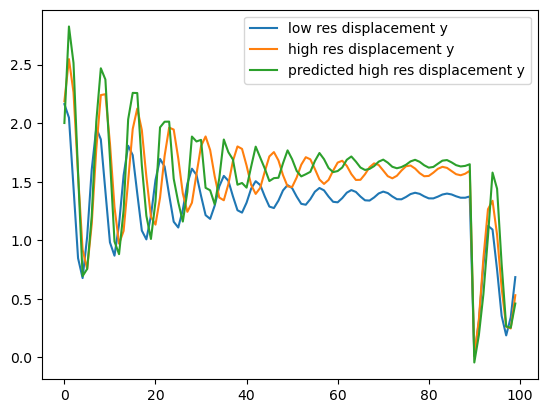

[2.16290524 2.04709366 1.45169921 0.84681088 0.67711468 1.03041827
 1.60294086 1.95876309 1.86154784 1.41957789 0.98175679 0.86821038
 1.1346582  1.55354741 1.80695513 1.72680947 1.39926004 1.08264599
 1.00736919 1.2080009  1.51429269 1.69440226 1.62925165 1.38683876
 1.15809136 1.10873913 1.2595611  1.48333229 1.61104359 1.55870463
 1.37955395 1.21435591 1.18242774 1.29569291 1.459192   1.54964027
 1.50793646 1.37555547 1.25628854 1.23598964 1.3209757  1.44041191
 1.50438898 1.47140594 1.37362351 1.2875811  1.274965   1.33867001
 1.42583034 1.47099093 1.4450925  1.37296254 1.31095805 1.30334127
 1.35101897 1.41460559 1.44640322 1.42617213 1.37300566 1.32830377
 1.32392023 1.359578   1.40604866 1.42846721 1.41269687 1.37340962
 1.34114262 1.33878546 1.3654921  1.39951087 1.41530676 1.40305977
 1.37401662 1.35067904 1.34955026 1.3695378  1.39445743 1.40561306
 1.39619328 1.37470192 1.35778305 1.35737198 1.3723395  1.39056874
 1.39850249 1.39127595 1.37539929 1.36311648 1.3630622  1.3742

In [124]:
# same on validation data

with th.no_grad():
    val_predictions = model(val_dataset.inputs.to(device)).cpu().numpy()
    print(val_predictions.shape)

print(val_predictions.shape)
print(val_data.shape)
plt.figure()
plt.plot(val_data[10, 0, :], label="low res displacement y")
plt.plot(val_data[10, 1, :], label="high res displacement y")
plt.plot(val_data[10, 0, :] + val_predictions[10, :, 0], label="predicted high res displacement y")
plt.legend()
plt.show()
print(val_data[10, 0, :])